In [ ]:
from osgeo import gdal
import numpy as np
import sys
import cv2 
from PIL import Image
from joblib import load
import matplotlib.pyplot as plt
#from MSATwtdenoiser import MSATdenoise
import matplotlib.image as mpimg
import scipy as sp
import scipy.ndimage
import skimage.measure  
import skimage.measure
import pywt
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score

In [ ]:
#@title
def box(img, r):
    """ O(1) box filter
        img - >= 2d image
        r   - radius of box filter
    """
    (rows, cols) = img.shape[:2]
    imDst = np.zeros_like(img)


    tile = [1] * img.ndim
    tile[0] = r
    imCum = np.cumsum(img, 0)
    imDst[0:r+1, :, ...] = imCum[r:2*r+1, :, ...]
    imDst[r+1:rows-r, :, ...] = imCum[2*r+1:rows, :, ...] - imCum[0:rows-2*r-1, :, ...]
    imDst[rows-r:rows, :, ...] = np.tile(imCum[rows-1:rows, :, ...], tile) - imCum[rows-2*r-1:rows-r-1, :, ...]

    tile = [1] * img.ndim
    tile[1] = r
    imCum = np.cumsum(imDst, 1)
    imDst[:, 0:r+1, ...] = imCum[:, r:2*r+1, ...]
    imDst[:, r+1:cols-r, ...] = imCum[:, 2*r+1 : cols, ...] - imCum[:, 0 : cols-2*r-1, ...]
    imDst[:, cols-r: cols, ...] = np.tile(imCum[:, cols-1:cols, ...], tile) - imCum[:, cols-2*r-1 : cols-r-1, ...]

    return imDst

def _gf_color(I, p, r, eps, s=None):
    """ Color guided filter
    I - guide image (rgb)
    p - filtering input (single channel)
    r - window radius
    eps - regularization (roughly, variance of non-edge noise)
    s - subsampling factor for fast guided filter
    """
    fullI = I
    fullP = p
    if s is not None:
        I = sp.ndimage.zoom(fullI, [1/s, 1/s, 1], order=1)
        p = sp.ndimage.zoom(fullP, [1/s, 1/s], order=1)
        r = round(r / s)

    h, w = p.shape[:2]
    N = box(np.ones((h, w)), r)

    mI_r = box(I[:,:,0], r) / N
    mI_g = box(I[:,:,1], r) / N
    mI_b = box(I[:,:,2], r) / N

    mP = box(p, r) / N

    # mean of I * p
    mIp_r = box(I[:,:,0]*p, r) / N
    mIp_g = box(I[:,:,1]*p, r) / N
    mIp_b = box(I[:,:,2]*p, r) / N

    # per-patch covariance of (I, p)
    covIp_r = mIp_r - mI_r * mP
    covIp_g = mIp_g - mI_g * mP
    covIp_b = mIp_b - mI_b * mP

    # symmetric covariance matrix of I in each patch:
    #       rr rg rb
    #       rg gg gb
    #       rb gb bb
    var_I_rr = box(I[:,:,0] * I[:,:,0], r) / N - mI_r * mI_r;
    var_I_rg = box(I[:,:,0] * I[:,:,1], r) / N - mI_r * mI_g;
    var_I_rb = box(I[:,:,0] * I[:,:,2], r) / N - mI_r * mI_b;

    var_I_gg = box(I[:,:,1] * I[:,:,1], r) / N - mI_g * mI_g;
    var_I_gb = box(I[:,:,1] * I[:,:,2], r) / N - mI_g * mI_b;

    var_I_bb = box(I[:,:,2] * I[:,:,2], r) / N - mI_b * mI_b;

    a = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            sig = np.array([
                [var_I_rr[i,j], var_I_rg[i,j], var_I_rb[i,j]],
                [var_I_rg[i,j], var_I_gg[i,j], var_I_gb[i,j]],
                [var_I_rb[i,j], var_I_gb[i,j], var_I_bb[i,j]]
            ])
            covIp = np.array([covIp_r[i,j], covIp_g[i,j], covIp_b[i,j]])
            a[i,j,:] = np.linalg.solve(sig + eps * np.eye(3), covIp)

    b = mP - a[:,:,0] * mI_r - a[:,:,1] * mI_g - a[:,:,2] * mI_b

    meanA = box(a, r) / N[...,np.newaxis]
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, [s, s, 1], order=1)
        meanB = sp.ndimage.zoom(meanB, [s, s], order=1)

    q = np.sum(meanA * fullI, axis=2) + meanB

    return q


def _gf_gray(I, p, r, eps, s=None):
    """ grayscale (fast) guided filter
        I - guide image (1 channel)
        p - filter input (1 channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if s is not None:
        Isub = sp.ndimage.zoom(I, 1/s, order=1)
        Psub = sp.ndimage.zoom(p, 1/s, order=1)
        r = round(r / s)
    else:
        Isub = I
        Psub = p


    (rows, cols) = Isub.shape

    N = box(np.ones([rows, cols]), r)

    meanI = box(Isub, r) / N
    meanP = box(Psub, r) / N
    corrI = box(Isub * Isub, r) / N
    corrIp = box(Isub * Psub, r) / N
    varI = corrI - meanI * meanI
    covIp = corrIp - meanI * meanP


    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = box(a, r) / N
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, s, order=1)
        meanB = sp.ndimage.zoom(meanB, s, order=1)

    q = meanA * I + meanB
    return q


def _gf_colorgray(I, p, r, eps, s=None):
    """ automatically choose color or gray guided filter based on I's shape """
    if I.ndim == 2 or I.shape[2] == 1:
        return _gf_gray(I, p, r, eps, s)
    elif I.ndim == 3 and I.shape[2] == 3:
        return _gf_color(I, p, r, eps, s)
    else:
        print("Invalid guide dimensions:", I.shape)
def guided_filter(I, p, r, eps, s=None):
    """ run a guided filter per-channel on filtering input p
        I - guide image (1 or 3 channel)
        p - filter input (n channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if p.ndim == 2:
        p3 = p[:,:,np.newaxis]

    out = np.zeros_like(p3)
    for ch in range(p3.shape[2]):
        out[:,:,ch] = _gf_colorgray(I, p3[:,:,ch], r, eps, s)
    return np.squeeze(out) if p.ndim == 2 else out

In [ ]:
#@title
import scipy as sp
import scipy.ndimage

def box(img, r):
    """ O(1) box filter
        img - >= 2d image
        r   - radius of box filter
    """
    (rows, cols) = img.shape[:2]
    imDst = np.zeros_like(img)


    tile = [1] * img.ndim
    tile[0] = r
    imCum = np.cumsum(img, 0)
    imDst[0:r+1, :, ...] = imCum[r:2*r+1, :, ...]
    imDst[r+1:rows-r, :, ...] = imCum[2*r+1:rows, :, ...] - imCum[0:rows-2*r-1, :, ...]
    imDst[rows-r:rows, :, ...] = np.tile(imCum[rows-1:rows, :, ...], tile) - imCum[rows-2*r-1:rows-r-1, :, ...]

    tile = [1] * img.ndim
    tile[1] = r
    imCum = np.cumsum(imDst, 1)
    imDst[:, 0:r+1, ...] = imCum[:, r:2*r+1, ...]
    imDst[:, r+1:cols-r, ...] = imCum[:, 2*r+1 : cols, ...] - imCum[:, 0 : cols-2*r-1, ...]
    imDst[:, cols-r: cols, ...] = np.tile(imCum[:, cols-1:cols, ...], tile) - imCum[:, cols-2*r-1 : cols-r-1, ...]

    return imDst

def _gf_color(I, p, r, eps, s=None):
    """ Color guided filter
    I - guide image (rgb)
    p - filtering input (single channel)
    r - window radius
    eps - regularization (roughly, variance of non-edge noise)
    s - subsampling factor for fast guided filter
    """
    fullI = I
    fullP = p
    if s is not None:
        I = sp.ndimage.zoom(fullI, [1/s, 1/s, 1], order=1)
        p = sp.ndimage.zoom(fullP, [1/s, 1/s], order=1)
        r = round(r / s)

    h, w = p.shape[:2]
    N = box(np.ones((h, w)), r)

    mI_r = box(I[:,:,0], r) / N
    mI_g = box(I[:,:,1], r) / N
    mI_b = box(I[:,:,2], r) / N

    mP = box(p, r) / N

    # mean of I * p
    mIp_r = box(I[:,:,0]*p, r) / N
    mIp_g = box(I[:,:,1]*p, r) / N
    mIp_b = box(I[:,:,2]*p, r) / N

    # per-patch covariance of (I, p)
    covIp_r = mIp_r - mI_r * mP
    covIp_g = mIp_g - mI_g * mP
    covIp_b = mIp_b - mI_b * mP

    # symmetric covariance matrix of I in each patch:
    #       rr rg rb
    #       rg gg gb
    #       rb gb bb
    var_I_rr = box(I[:,:,0] * I[:,:,0], r) / N - mI_r * mI_r;
    var_I_rg = box(I[:,:,0] * I[:,:,1], r) / N - mI_r * mI_g;
    var_I_rb = box(I[:,:,0] * I[:,:,2], r) / N - mI_r * mI_b;

    var_I_gg = box(I[:,:,1] * I[:,:,1], r) / N - mI_g * mI_g;
    var_I_gb = box(I[:,:,1] * I[:,:,2], r) / N - mI_g * mI_b;

    var_I_bb = box(I[:,:,2] * I[:,:,2], r) / N - mI_b * mI_b;

    a = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            sig = np.array([
                [var_I_rr[i,j], var_I_rg[i,j], var_I_rb[i,j]],
                [var_I_rg[i,j], var_I_gg[i,j], var_I_gb[i,j]],
                [var_I_rb[i,j], var_I_gb[i,j], var_I_bb[i,j]]
            ])
            covIp = np.array([covIp_r[i,j], covIp_g[i,j], covIp_b[i,j]])
            a[i,j,:] = np.linalg.solve(sig + eps * np.eye(3), covIp)

    b = mP - a[:,:,0] * mI_r - a[:,:,1] * mI_g - a[:,:,2] * mI_b

    meanA = box(a, r) / N[...,np.newaxis]
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, [s, s, 1], order=1)
        meanB = sp.ndimage.zoom(meanB, [s, s], order=1)

    q = np.sum(meanA * fullI, axis=2) + meanB

    return q


def _gf_gray(I, p, r, eps, s=None):
    """ grayscale (fast) guided filter
        I - guide image (1 channel)
        p - filter input (1 channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if s is not None:
        Isub = sp.ndimage.zoom(I, 1/s, order=1)
        Psub = sp.ndimage.zoom(p, 1/s, order=1)
        r = round(r / s)
    else:
        Isub = I
        Psub = p


    (rows, cols) = Isub.shape

    N = box(np.ones([rows, cols]), r)

    meanI = box(Isub, r) / N
    meanP = box(Psub, r) / N
    corrI = box(Isub * Isub, r) / N
    corrIp = box(Isub * Psub, r) / N
    varI = corrI - meanI * meanI
    covIp = corrIp - meanI * meanP


    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = box(a, r) / N
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, s, order=1)
        meanB = sp.ndimage.zoom(meanB, s, order=1)

    q = meanA * I + meanB
    return q


def _gf_colorgray(I, p, r, eps, s=None):
    """ automatically choose color or gray guided filter based on I's shape """
    if I.ndim == 2 or I.shape[2] == 1:
        return _gf_gray(I, p, r, eps, s)
    elif I.ndim == 3 and I.shape[2] == 3:
        return _gf_color(I, p, r, eps, s)
    else:
        print("Invalid guide dimensions:", I.shape)
def guided_filter(I, p, r, eps, s=None):
    """ run a guided filter per-channel on filtering input p
        I - guide image (1 or 3 channel)
        p - filter input (n channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if p.ndim == 2:
      p3 = p[:,:,np.newaxis]
    else:
      p3 = p[:,:,[0]]
    print(p3.shape)
    out = np.zeros_like(p3)
    for ch in range(p3.shape[2]):
        out[:,:,ch] = _gf_colorgray(I, p3[:,:,ch], r, eps, s)
    return np.squeeze(out) if p.ndim == 2 else out

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pan = Image.open('/content/drive/MyDrive/ProjectWork/data/pant.png') # PAN Chromatic
#pan = Image.open('/content/drive/MyDrive/data/pant.png') # PAN Chromatic

In [ ]:
ms = Image.open('/content/drive/MyDrive/ProjectWork/data/rmst.png') # real MS file
#ms = Image.open('/content/drive/MyDrive/data/rmst.png') # real MS file

In [ ]:
pan.size

(512, 512)

In [ ]:
ms.size

(128, 128)

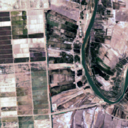

In [ ]:
ms

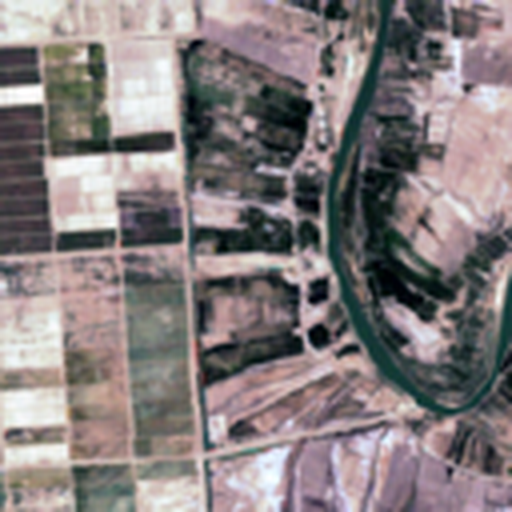

In [ ]:
xms = ms.resize((512,512),resample=Image.LANCZOS)
xms


In [ ]:
ms_array = np.array(xms)

Wavelet transformation on MS

In [ ]:
# some configuration
plt.rcParams['figure.figsize'] = [6,6]
plt.rcParams.update({'font.size':18})

In [ ]:
# seperating each band 
r,g,b = [c.T for c in ms_array.T]

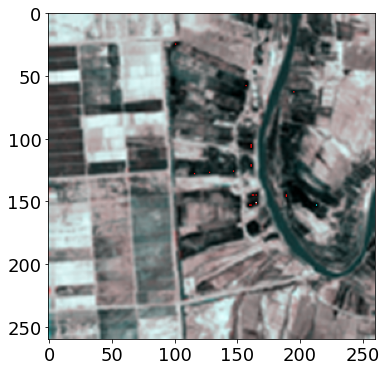

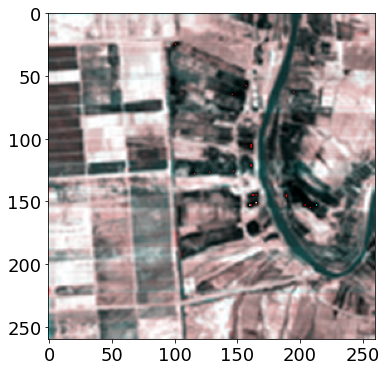

In [ ]:
n = 1
w = 'db5'
coeffsR = pywt.wavedec2(r,wavelet=w,level=n,mode='smooth')
cR = coeffsR.copy()
# normalize each coefficient Array
coeffsR[0] /= np.abs(coeffsR[0]).max()
for detail_level in range(n):
  coeffsR[detail_level + 1] = [d/np.abs(d).max() for d in coeffsR[detail_level]]

# plt.imshow(coeffsR[0], cmap='Reds')
# plt.show()
# plt.imshow(coeffsR[1], cmap='Reds')
# plt.show()

coeffsG = pywt.wavedec2(g,wavelet=w,level=n)
cG = coeffsG.copy()
coeffsG[0] /= np.abs(coeffsG[0]).max()
for detail_level in range(n):
    coeffsG[detail_level + 1] = [d/np.abs(d).max() for d in coeffsG[detail_level]]
# plt.imshow(coeffsG[0],cmap='Greens')
# plt.show()
# plt.imshow(coeffsG[1],cmap='Greens')
# plt.show()

coeffsB = pywt.wavedec2(g,wavelet=w,level=n)
cB = coeffsB.copy()
coeffsB[0] /= np.abs(coeffsB[0]).max()
for detail_level in range(n):
    coeffsB[detail_level + 1] = [d/np.abs(d).max() for d in coeffsB[detail_level]]
# plt.imshow(coeffsB[0],cmap='Blues')
# plt.show()
# plt.imshow(coeffsB[1],cmap='Blues')
# plt.show()

lowMS = (np.dstack((coeffsR[0],coeffsG[0],coeffsB[0]))*255.999).astype(np.uint8)
plt.imshow(lowMS)
plt.show()
hiMS = (np.dstack((coeffsR[-1],coeffsG[-1],coeffsB[-1]))*255.999).astype(np.uint8)
plt.imshow(hiMS)
plt.show()

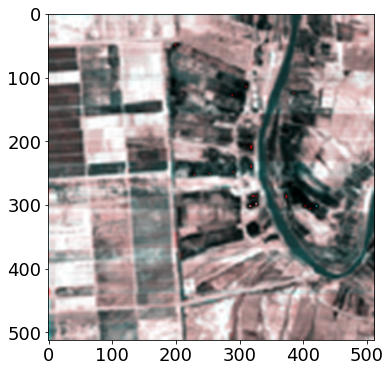

In [ ]:
rhiMS= cv2.resize(hiMS, (512,512))
rhiMS
plt.imshow(rhiMS)

guided filter on high coefficient of wavelet ms

(512, 512, 1)


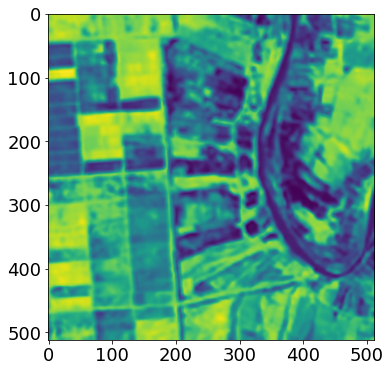

In [ ]:
xms_arr2 = rhiMS.astype(np.float32) / 255
r = 2
eps = 0.01
xms2 = ms_array.astype(np.float32) / 255
l1_1 = guided_filter(xms_arr2,xms2, r, eps)
l1_1 = l1_1.reshape((512,512))
plt.imshow(l1_1)


plt.show()

In [ ]:
!pip install sewar

  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=17534c5d7285eb65383e97896c1b584ccd41a3d27e27344cb4dc996350ba6b5c
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


In [ ]:
from sewar.full_ref import uqi

In [ ]:
uqi(l1_1, rhiMS[:,:,0])

/usr/local/lib/python3.7/dist-packages/sewar/utils.py:18: UserWarning: Supplied images have different dtypes float32 and uint8
  warnings.warn(msg)


5.870380946371789e-05

WT on pan

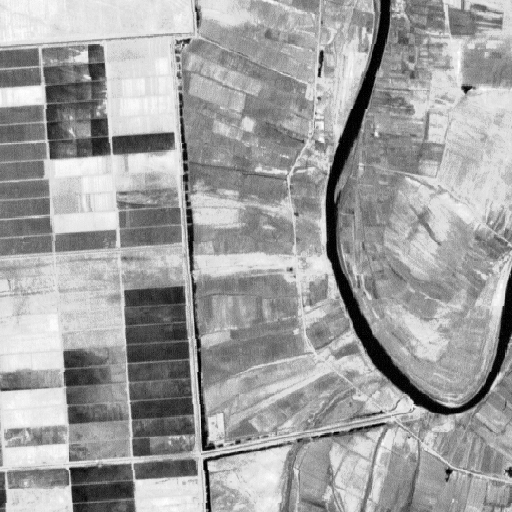

In [ ]:
pan

In [ ]:
pan.size

(512, 512)

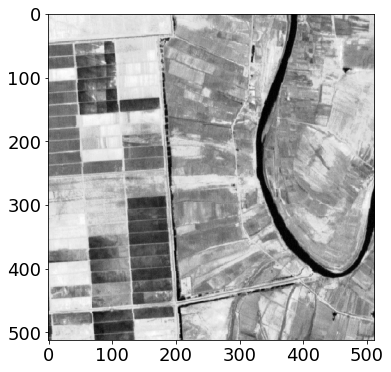

In [ ]:
pan_array = cv2.cvtColor(np.array(pan),cv2.COLOR_BGR2GRAY)
plt.imshow(pan_array,cmap='gray')

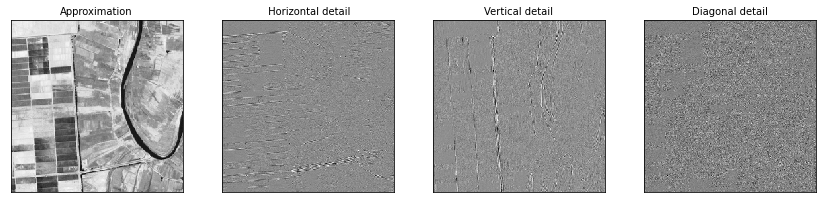

In [ ]:
# Load image
original = pan_array

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, w)
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

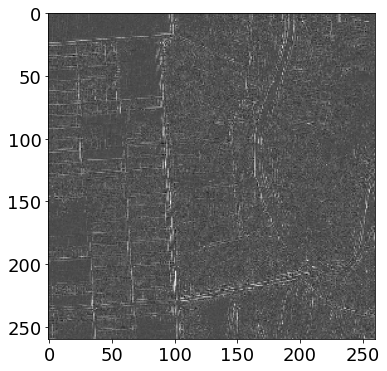

In [ ]:
high_coeff= np.maximum( LH, HL, HH)
plt.imshow(high_coeff, cmap= 'gray')

(512, 512)


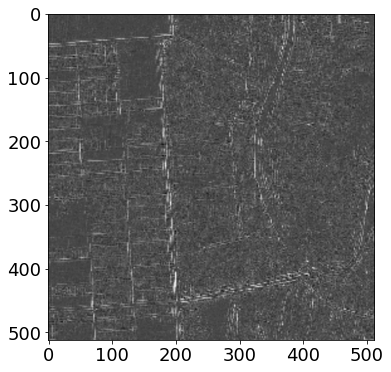

In [ ]:
rhipan= cv2.resize(high_coeff, (512,512))
rhipan
plt.imshow(rhipan, cmap= 'gray')
print(rhipan.shape)

In [ ]:
#@title
def hist_norm(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """
    olddtype = source.dtype
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    interp_t_values = interp_t_values.astype(olddtype)

    return interp_t_values[bin_idx].reshape(oldshape)

In [ ]:
#@title
# pan_array = np.array(pan)
# matched_pan = hist_norm(pan_array,ms_array)
# plt.figure(figsize=(10,10))
# plt.xticks([])
# plt.yticks([])
# plt.imshow(matched_pan)
# plt.show()

In [ ]:
#@title
# pan_arr = np.mean(pan_array,axis=2)
# pan_arr = pan_arr+np.random.normal(0,100,[np.shape(pan_arr)[0],np.shape(pan_arr)[1]])
# denoiser = MSATdenoise(pan_arr,'db3',1) # wavelet name from dt1 to dt5 and level from 1 to 5
# denoised_img2 = denoiser.denoised

In [ ]:
#@title
# fig = plt.figure(figsize=(12, 3))
# ax = fig.add_subplot(1, 3, 1)
# ax.imshow(pan_array, interpolation="nearest", cmap=plt.cm.gray)
# ax = fig.add_subplot(1, 3, 2)
# ax.imshow(pan_arr, interpolation="nearest", cmap=plt.cm.gray)
# ax = fig.add_subplot(1, 3, 3)
# ax.imshow(denoised_img2, interpolation="nearest", cmap=plt.cm.gray)
# fig.tight_layout() #automatically adjust subplot parameters to give specified padding
# plt.show()

guided filter on high coefficient of pan

In [ ]:
xpan2 = pan_array.astype(np.float32) / 255
xpan2.shape

(512, 512)

In [ ]:
rhipan.shape

(512, 512)

(512, 512, 1)


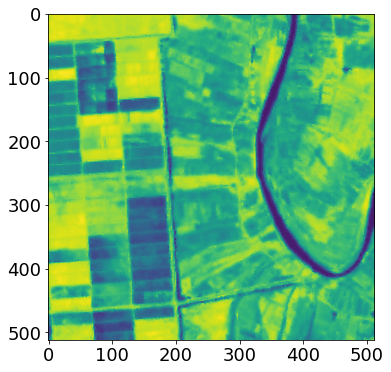

In [ ]:
r = 2
eps = 0.01
xpan_arr2 = rhipan.astype(np.float32) / 255
l2_1 = guided_filter(rhipan,xpan2, r, eps)



plt.imshow(l2_1)

plt.show()

In [ ]:
uqi(l2_1, rhipan)

/usr/local/lib/python3.7/dist-packages/sewar/utils.py:18: UserWarning: Supplied images have different dtypes float32 and float64
  warnings.warn(msg)


0.06971871694551243

fusion of high coefficients of ms and pan

In [ ]:
l1_1.shape

(512, 512)

In [ ]:
l2_1.shape

(512, 512)

In [ ]:
high_fused_array= np.maximum(l1_1,l2_1)
plt.show()

In [ ]:
high_fused_array.size

262144

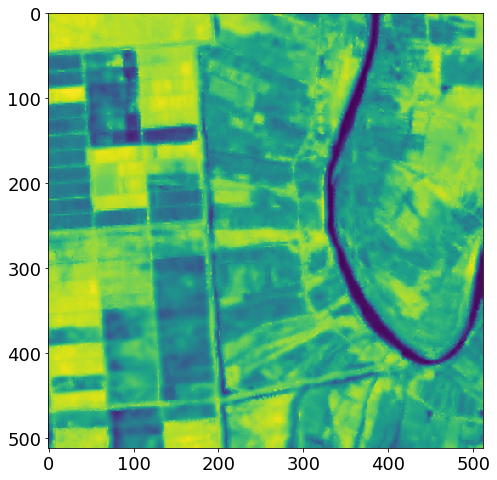

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(high_fused_array, interpolation="nearest")
plt.show()

fusion of low coefficients of ms and pan

In [ ]:
cv2.cvtColor(lowMS,cv2.COLOR_BGR2GRAY).shape

(260, 260)

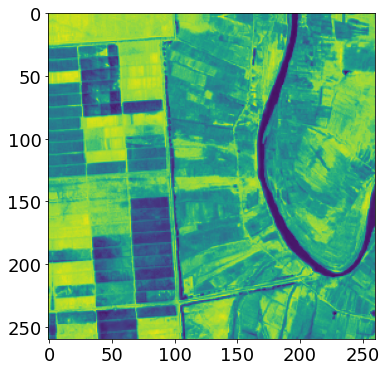

In [ ]:
lowMS2 = cv2.cvtColor(lowMS,cv2.COLOR_BGR2GRAY)
low_fused_array= np.maximum(lowMS2,LL)
plt.imshow(low_fused_array)
plt.show()
low_fused_array = cv2.resize(low_fused_array,high_fused_array.shape)

In [ ]:
low_fused_array.shape

(512, 512)

IDWT

In [ ]:

A = pywt.idwt(high_fused_array, None, 'db3', 'smooth')
D = pywt.idwt(low_fused_array, None, 'db3', 'smooth')
fused= A + D

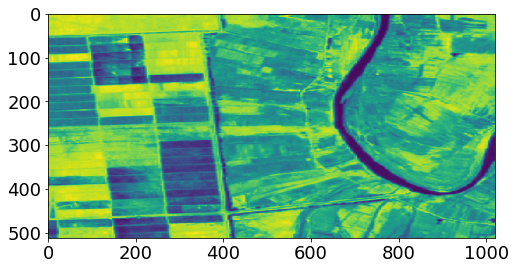

In [ ]:
fig4 = plt.figure(figsize=(8, 8))
plt.imshow(fused, interpolation="nearest")
plt.show()

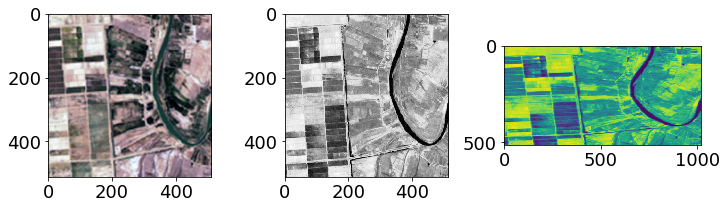

In [ ]:

fig6 = plt.figure(figsize=(12, 3))
ax = fig6.add_subplot(1, 3, 1)
ax.imshow(ms_array, interpolation="nearest")
ax = fig6.add_subplot(1, 3, 2)
ax.imshow(pan_array, interpolation="nearest", cmap ='gray')
ax = fig6.add_subplot(1, 3, 3)
ax.imshow(fused, interpolation="nearest")
plt.show()

In [ ]:
entropy = skimage.measure.shannon_entropy(pan_array)
print(entropy)

5.861638507124967


In [ ]:
entropy = skimage.measure.shannon_entropy(ms_array)
print(entropy)

7.846173377865524


In [ ]:
entropy = skimage.measure.shannon_entropy(fused)
print(entropy)

18.99435343685886


In [ ]:
print("MS STD", ms_array.std())
print("PAN STD", pan_array.std())
print("FINAL STD",fused.std())

MS STD 59.04396529856266
PAN STD 54.754252530944136
FINAL STD 72.52079721153628


In [ ]:
import math
import numpy as np
import cv2

def ssim(ms_array, fused):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    m = ms_array.astype(np.float64)
    f = fused.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(m, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(f, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(m**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(f**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(m * f, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(m, f):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not m.shape == f.shape:
        raise ValueError('Input images must have the same dimensions.')
    if m.ndim == 2:
        return ssim(m, f)
    elif m.ndim == 3:
        if m.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(m, f))
            return np.array(ssims).mean()
        elif m.shape[2] == 1:
            return ssim(np.squeeze(m), np.squeeze(f))
    else:
        raise ValueError('Wrong input image dimensions.')

In [ ]:
ms_array = cv2.cvtColor(ms_array, cv2.COLOR_BGR2GRAY)

In [ ]:
ms_array.reshape(502,1010)

ValueError: ignored

In [ ]:
ssim(ms_array.resize(502,1010),fused)

ValueError: ignored

In [ ]:
!pip install sewar

In [ ]:
from sewar.full_ref import uqi

In [ ]:
fused= cv2.resize(fused, (512,512))
fused
plt.imshow(fused, cmap= 'gist_earth_r')

In [ ]:
uqi(pan_array,fused)

In [ ]:
uqi(cv2.cvtColor(ms_array,cv2.COLOR_BGR2GRAY),fused)

In [ ]:
mutual_info_classif?

In [ ]:
pan_array = pan_array.astype(np.uint8)
ms_array = ms_array.astype(np.uint8)
ms_gray_array = cv2.cvtColor(ms_array, cv2.COLOR_BGR2GRAY)
ms_gray_array = cv2.resize(ms_gray_array,pan_array.shape)
final_fused_array = fused.astype(np.uint8)

In [ ]:
print(mutual_info_classif(ms_gray_array.ravel().reshape(-1,1), fused.ravel(), discrete_features = 'auto'))
print(mutual_info_score(ms_gray_array.ravel(), fused.ravel())) # info

In [ ]:
print(mutual_info_classif(pan_array.ravel().reshape(-1,1),fused.ravel(), discrete_features = 'auto'))
print(mutual_info_score(pan_array.ravel(), final_fused_array.ravel())) # info